In [173]:
import xarray as xr
import sys
sys.path.append("../")

In [174]:
#Case study needs fixing 
glofas = xr.open_dataset('./glofas_masked_elbe_2012-2016.nc')

glofas

<xarray.Dataset>
Dimensions:    (latitude: 54, longitude: 71, time: 1827)
Coordinates:
  * latitude   (latitude) float64 53.85 53.75 53.65 53.55 ... 48.75 48.65 48.55
  * longitude  (longitude) float64 9.25 9.35 9.45 9.55 ... 16.05 16.15 16.25
  * time       (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2016-12-31
Data variables:
    dis24      (time, latitude, longitude) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.9.6 (http://m...
    Conventions:               CF-1.6
    history:                   Thu Oct 10 12:28:51 2019: cdo -seldate,1999-01...
    cdo_openmp_thread_number:  8
    NCO:                       netCDF Operators version 4.7.8 (Homepage = htt...
    CDO:                       Climate Data Operators version 1.9.6 (http://m...

In [152]:
from functions.floodmodel_utils import get_basin_mask, get_river_mask

In [153]:
#eps = xr.open_mfdataset('/tmp/flood_prediction/pipeline/glofas2.1_2018_areagrid_for_StevenGong_in_Europe_*.nc', combine="nested", concat_dim='time')
eps = xr.open_dataset('/tmp/flood_prediction/pipeline/glofas2.1_2018_areagrid_for_StevenGong_in_Europe_2013051400.nc')

In [154]:
eps = eps.rename({'lat': 'latitude'})
eps = eps.rename({'lon': 'longitude'})

eps

<xarray.Dataset>
Dimensions:    (ensemble: 11, latitude: 450, longitude: 750, time: 31)
Coordinates:
  * time       (time) datetime64[ns] 2013-05-14 2013-05-15 ... 2013-06-13
  * longitude  (longitude) float32 -24.95 -24.85 -24.75 ... 49.75 49.85 49.95
  * latitude   (latitude) float32 74.95 74.85 74.75 74.65 ... 30.25 30.15 30.05
  * ensemble   (ensemble) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
Data variables:
    ups        (latitude, longitude) float32 ...
    ldd        (latitude, longitude) float32 ...
    rl2        (latitude, longitude) float32 ...
    rl5        (latitude, longitude) float32 ...
    rl20       (latitude, longitude) float32 ...
    dis        (time, ensemble, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    history:      Fri Feb 14 21:35:09 2020: cdo -f nc4 -z zip copy tmp.nc /vo...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

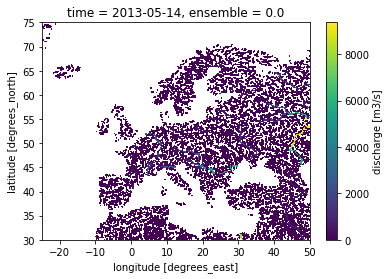

In [155]:
eps.isel(time=0, ensemble=0)['dis'].plot()

In [156]:
elbe_basin_mask = get_basin_mask(eps.isel(time=0, ensemble=0)['dis'], 'Elbe')

In [157]:
eps_masked = eps.where(elbe_basin_mask, drop=True)
eps_masked

<xarray.Dataset>
Dimensions:    (ensemble: 11, latitude: 54, longitude: 71, time: 31)
Coordinates:
  * time       (time) datetime64[ns] 2013-05-14 2013-05-15 ... 2013-06-13
  * longitude  (longitude) float32 9.25 9.35 9.45 9.55 ... 16.05 16.15 16.25
  * latitude   (latitude) float32 53.85 53.75 53.65 53.55 ... 48.75 48.65 48.55
  * ensemble   (ensemble) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
Data variables:
    ups        (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    ldd        (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    rl2        (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    rl5        (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    rl20       (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    dis        (time, ensemble, latitude, longitude) float32 nan nan ... nan nan
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    history:      Fri Feb 14 21:35:09 2020: cdo -f nc4 -z zip copy tmp.nc /vo...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

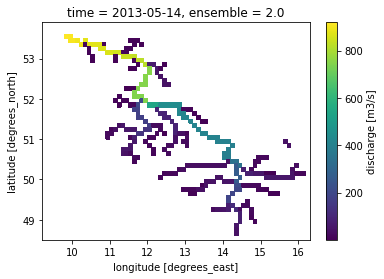

In [158]:
eps_masked.isel(time=0, ensemble=2)['dis'].plot()

In [159]:
eps_masked

<xarray.Dataset>
Dimensions:    (ensemble: 11, latitude: 54, longitude: 71, time: 31)
Coordinates:
  * time       (time) datetime64[ns] 2013-05-14 2013-05-15 ... 2013-06-13
  * longitude  (longitude) float32 9.25 9.35 9.45 9.55 ... 16.05 16.15 16.25
  * latitude   (latitude) float32 53.85 53.75 53.65 53.55 ... 48.75 48.65 48.55
  * ensemble   (ensemble) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
Data variables:
    ups        (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    ldd        (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    rl2        (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    rl5        (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    rl20       (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    dis        (time, ensemble, latitude, longitude) float32 nan nan ... nan nan
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    history:      Fri Feb 14 21:35:09 2020: cdo -f nc4 -z zip copy tmp.nc /vo...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

In [160]:
#instead of taking the mean you should take a specific point
mean_eps_masked = eps_masked.mean(['latitude', 'longitude'])['dis']
mean_eps_masked

<xarray.DataArray 'dis' (time: 31, ensemble: 11)>
array([[186.05667, 186.05667, 186.05667, 186.05667, 186.05667, 186.05667,
        186.05667, 186.05667, 186.05667, 186.05667, 186.05667],
       [182.19678, 182.22098, 182.10135, 182.33243, 182.11943, 182.21588,
        182.11153, 182.20418, 182.24567, 182.16359, 182.3384 ],
       [176.05054, 176.78343, 176.41534, 176.61494, 176.55383, 177.03426,
        176.44249, 176.28514, 176.6385 , 176.4926 , 176.70876],
       [169.39934, 171.46034, 170.8223 , 170.64032, 171.25677, 172.10786,
        170.88283, 170.07013, 171.17946, 170.67938, 170.88962],
       [164.99362, 167.81271, 170.13335, 166.55453, 168.99358, 168.06454,
        169.93042, 170.45396, 166.6991 , 166.68394, 168.2047 ],
       [161.27753, 165.41762, 169.07263, 163.2462 , 167.55765, 165.17017,
        168.82858, 169.37685, 164.45473, 163.89313, 167.25404],
       [157.70349, 165.4451 , 167.3131 , 159.96979, 166.67412, 163.67757,
        177.24438, 167.16605, 162.55539, 161.38672, 165.09554],
       [165.23071, 167.65039, 168.06026, 158.59634, 172.46243, 162.30128,
        190.86905, 166.37306, 160.14366, 165.17027, 164.33678],
       [175.72224, 171.89093, 170.6267 , 181.61035, 178.97293, 162.08134,
        202.35983, 165.937  , 158.37726, 173.96008, 165.54051],
       [181.7867 , 179.78389, 170.19733, 193.34038, 191.66911, 163.27937,
        207.87097, 163.56029, 157.45853, 176.90001, 163.96985],
       [184.87006, 184.76068, 175.36652, 194.48068, 199.34053, 162.81528,
        208.92729, 159.22902, 155.60776, 176.78917, 160.65866],
       [188.62723, 186.81082, 183.64183, 196.92644, 199.40082, 161.25214,
        207.8649 , 155.32875, 153.64438, 175.16861, 156.8092 ],
       [189.88924, 185.57016, 189.5829 , 191.6652 , 196.70865, 160.50345,
        203.38434, 151.16301, 152.36066, 172.99551, 154.03154],
       [186.44737, 181.03189, 192.26817, 183.06982, 190.65604, 159.38821,
        196.7272 , 147.65291, 150.51517, 169.62825, 156.02924],
       [180.185  , 175.47087, 192.07019, 174.7969 , 182.9701 , 157.18117,
        193.07002, 145.40991, 148.42831, 166.10071, 156.74223],
       [172.62589, 169.9702 , 188.90407, 167.41484, 176.15654, 156.14507,
        189.58665, 144.13266, 146.26273, 163.13483, 156.07928],
       [164.28876, 165.42125, 184.46008, 161.514  , 171.43428, 154.77913,
        185.20879, 142.58539, 146.9285 , 159.91403, 154.46483],
       [156.5088 , 161.09431, 179.26404, 156.71364, 167.07327, 152.46944,
        182.83348, 140.74605, 150.4568 , 156.64215, 151.72795],
       [151.91849, 156.773  , 175.33531, 153.36903, 162.78445, 150.45758,
        181.176  , 139.25795, 164.0111 , 158.33609, 150.85811],
       [148.06918, 152.5541 , 171.26764, 150.72156, 159.82918, 147.78209,
        178.0347 , 137.55373, 171.2886 , 160.0988 , 149.37534],
       [144.50879, 149.39832, 168.11845, 149.51604, 156.55762, 144.66736,
        174.14339, 136.68446, 172.17781, 162.89957, 146.59023],
       [140.96526, 148.45589, 165.66463, 149.39174, 152.79002, 141.7815 ,
        170.1169 , 138.29773, 173.1425 , 171.10799, 143.97316],
       [136.90141, 147.48924, 162.04497, 148.92241, 149.30415, 139.21779,
        166.29742, 187.80951, 169.33005, 177.42207, 141.4045 ],
       [132.97644, 145.34453, 157.8256 , 149.79773, 148.2759 , 136.26054,
        162.54558, 232.2232 , 165.52682, 178.8492 , 139.5888 ],
       [165.73889, 143.32181, 153.36795, 149.69766, 151.7253 , 134.95454,
        158.98186, 247.42491, 162.55516, 176.50757, 137.87224],
       [184.00021, 140.74661, 148.77075, 148.26988, 187.37686, 140.88354,
        156.01057, 254.2467 , 158.39127, 171.44405, 135.8397 ],
       [186.17183, 137.56595, 144.2912 , 146.42448, 215.31541, 169.22055,
        153.49489, 242.49979, 156.3398 , 164.96523, 133.27885],
       [190.75363, 134.60971, 140.08409, 144.07564, 226.72145, 201.5903 ,
        151.11249, 225.73608, 154.09157, 159.14116, 130.30653],
       [183.106  , 132.33018, 136.15936, 141.5706 , 232.94147, 222.23396,
        151.

In [166]:
glofas_reshaped = glofas.loc[dict(time=slice('2013-05-13','2013-06-13'))].mean(['latitude','longitude'])

glofas_reshaped

<xarray.Dataset>
Dimensions:  (time: 32)
Coordinates:
  * time     (time) datetime64[ns] 2013-05-13 2013-05-14 ... 2013-06-13
Data variables:
    dis24    (time) float32 186.39113 183.62947 179.81519 ... 372.74426 373.2233

Text(0.5, 1.0, 'Comparison of LSTM Model with GloFAS 30-Day Ensemble Forecasts')

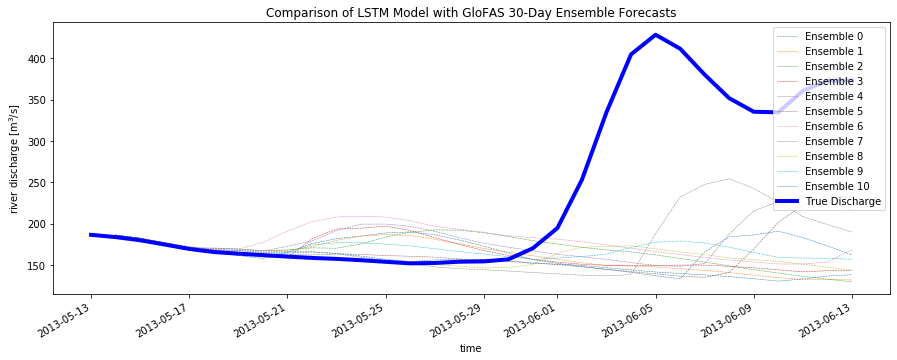

In [172]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))
color_scheme = ['g', 'cyan', 'magenta', 'k']


for ensemble_index in range(len(mean_eps_masked.ensemble)):
    mean_eps_masked.isel(ensemble=ensemble_index).plot(ax=ax, label=('Ensemble ' + str(ensemble_index)), lw=0.5, linestyle='--')
    
glofas_reshaped['dis24'].plot(ax=ax, label=('True Discharge'), lw=4, linestyle='-', color='blue')

ax.set_ylabel('river discharge [m$^3$/s]')

ax.legend(loc='upper right')                

plt.title('Comparison of LSTM Model with GloFAS 30-Day Ensemble Forecasts')